In [4]:
import torch
import torchvision
import matplotlib.pyplot as plt
import imp
from perceiver_basic import model
from torch.utils.data import DataLoader
from collections.abc import Iterable
from lamb import Lamb

In [5]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class FMPreprocess(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.shape = (1, 20, 20)
        self.encoding = self._generate_encoding()
        self.encoding = torch.nn.Parameter(self.encoding)
        self.encoding.requires_grad = False
        
        self.conv0 = torch.nn.Conv2d(1, 8, kernel_size=9, stride=1, bias=False)

    def _generate_encoding(self):
        dims = len(self.shape)-1 #minus batch dim
        encoding = torch.zeros([*self.shape, dims])
        for i in range(encoding[0].shape[0]):
            for j in range(encoding[0].shape[1]):
                encoding[0,i,j][0] = i * 2.0 / encoding[0].shape[0] - 1.0
                encoding[0,i,j][1] = i * 2.0 / encoding[0].shape[0] - 1.0
        return encoding

    def forward(self, in_val):
        x = in_val
        x = x.view([-1, 1, 28, 28])
        x = self.conv0(x)
        x = x.permute([0,3,2,1])
        #print(x.shape)
        batch_count = in_val.shape[0]
        dims = [-1 for _ in range(len(self.encoding.shape))]
        dims[0] = batch_count
        encoding = self.encoding.expand(*dims)
        x = torch.cat([x, encoding], dim=-1) #concatenating positional encodings
        #x = torch.mul(x, encoding) #scaled positional encoding
        
        #maintain batch and pixel codes, pixels will be in sequential form
        x = torch.flatten(x, start_dim=1, end_dim=-2)

        return x

In [7]:
pre = FMPreprocess()
print(len(list(pre.parameters())))
garbo = torch.randn([5, 28, 28])
pre(garbo).shape

2


torch.Size([5, 400, 10])

In [8]:
imp.reload(model)
class PerceiverClassify(torch.nn.Module):
    def __init__(self, latent_dim, heads, wide_factor, latent_count, repeat_count=1, p_dropout=0.1):
        super().__init__()
        self.preprocess = FMPreprocess()
        out_dim = (8,8)
        #in_channels = len(self.preprocess.shape) #subtract one for batch dim, but add one for the pixel dim
        in_channels = 10
        self.perceiver = model.PerceiverInternal(in_channels, latent_dim, out_dim, heads, wide_factor, latent_count, repeat_count, p_dropout)
        
        self.lin_out = torch.nn.Linear(64, 10)
        self.softmax = torch.nn.Softmax(-1)
        self.flatten = torch.nn.Flatten()

    def forward(self, x):
        #x = x / self.range
        x = self.preprocess(x)

        x = self.perceiver(x)
      
        # x.shape <- (batch_count, 1, 32)
        #x = x.squeeze()
        x = self.flatten(x)
        x = self.lin_out(x)
        x = self.softmax(x)

        return x

In [19]:
class GarbageNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.garbo = torch.nn.Sequential(
            torch.nn.Linear(28*28, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
            torch.nn.Softmax(-1),
        )
        self.flatten = torch.nn.Flatten()
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.garbo(x)
        return x

In [25]:
per = PerceiverClassify(latent_dim=(32, 32), heads=8, wide_factor=4, latent_count=6)
garbo = torch.randn([1, 28, 28])
per(garbo).shape

torch.Size([1, 10])

In [10]:
mh = torch.nn.MultiheadAttention(32, 8, vdim=7, kdim=7, batch_first=True)
q = torch.randn([3, 2, 32])
kv = torch.randn([3, 6, 7])
mh(q, kv, kv)[0].shape

torch.Size([3, 2, 32])

In [11]:
BATCH_SIZE = 32
EPOCHS = 10

In [12]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = torchvision.datasets.FashionMNIST('./fm_set', transform=transforms, download=True)
testset = torchvision.datasets.FashionMNIST('./fm_set', train=False, transform=transforms, download=True)

11.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

29.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

57.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

79.7%IOPub

Extracting ./fm_set/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fm_set/FashionMNIST/raw



119.3%

Extracting ./fm_set/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fm_set/FashionMNIST/raw



In [13]:
torch.max(dataset[0][0])

tensor(1.)

In [13]:
dataloader = DataLoader(dataset, num_workers=2, batch_size=BATCH_SIZE)

In [26]:
perceiver = PerceiverClassify(latent_dim=(16,16), heads=8, wide_factor=8, latent_count=16)
# perceiver = GarbageNet()
perceiver.to(device)
optimizer = Lamb(perceiver.parameters())
criterion = torch.nn.CrossEntropyLoss()

In [27]:
garbo = torch.randn([3, 28, 28])
garbo = garbo.to(device)
perceiver(garbo).shape

torch.Size([3, 10])

In [26]:
def get_grad(x):
    if x.grad != None:
        grad = x.grad.detach().cpu()
        
    return -69

In [27]:
torch.tensor([1]).shape

torch.Size([1])

In [28]:
def ret_grad_list(params):
    if isinstance(params, torch.Tensor) and len(params.shape) == 0:
        return [params.grad]
    garbo = [ret_grad_list(param) for param in params]
    product = []
    for garb in garbo:
        product += garb
    return product

In [29]:
paramsInit = [t.clone() for t in perceiver.parameters()]

Entering epoch 0
Iteration - 0 - loss 2.2977511882781982
Iteration - 1 - loss 2.292210578918457
Iteration - 2 - loss 2.3031363487243652
Iteration - 3 - loss 2.3167128562927246
Iteration - 4 - loss 2.3269639015197754
Iteration - 5 - loss 2.292872428894043
Iteration - 6 - loss 2.297130584716797
Iteration - 7 - loss 2.293252944946289
Iteration - 8 - loss 2.304126739501953
Iteration - 9 - loss 2.311216115951538
Iteration - 10 - loss 2.2898950576782227
Iteration - 11 - loss 2.3078386783599854
Iteration - 12 - loss 2.3040807247161865
Iteration - 13 - loss 2.3152225017547607
Iteration - 14 - loss 2.299828052520752
Iteration - 15 - loss 2.300443649291992
Iteration - 16 - loss 2.3046493530273438
Iteration - 17 - loss 2.3073461055755615
Iteration - 18 - loss 2.3031139373779297
Iteration - 19 - loss 2.3059568405151367
Iteration - 20 - loss 2.295964479446411
Iteration - 21 - loss 2.3053600788116455
Iteration - 22 - loss 2.2992031574249268
Iteration - 23 - loss 2.3058526515960693
Iteration - 24 - l

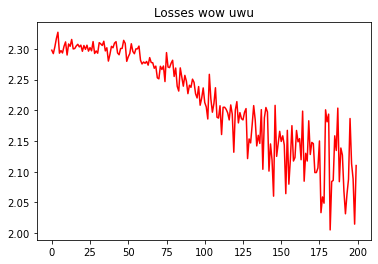

Iteration - 200 - loss 2.092944860458374
Iteration - 201 - loss 2.195268392562866
Iteration - 202 - loss 2.193251132965088
Iteration - 203 - loss 2.105231761932373
Iteration - 204 - loss 2.056288957595825
Iteration - 205 - loss 2.1718177795410156
Iteration - 206 - loss 2.1081013679504395
Iteration - 207 - loss 2.075976610183716
Iteration - 208 - loss 2.0326731204986572
Iteration - 209 - loss 1.9817330837249756
Iteration - 210 - loss 2.085794448852539
Iteration - 211 - loss 2.1083974838256836
Iteration - 212 - loss 1.974304437637329
Iteration - 213 - loss 2.064680814743042
Iteration - 214 - loss 2.029262065887451
Iteration - 215 - loss 2.102543830871582
Iteration - 216 - loss 2.1406781673431396
Iteration - 217 - loss 2.0322959423065186
Iteration - 218 - loss 2.103904962539673
Iteration - 219 - loss 2.0784764289855957
Iteration - 220 - loss 2.0245161056518555
Iteration - 221 - loss 2.013432264328003
Iteration - 222 - loss 2.0082757472991943
Iteration - 223 - loss 2.0228114128112793
Itera

Iteration - 398 - loss 2.028428792953491
Iteration - 399 - loss 1.9835267066955566


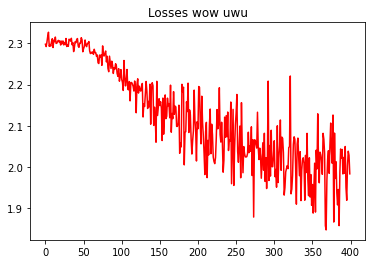

Iteration - 400 - loss 1.9335910081863403
Iteration - 401 - loss 1.9193778038024902
Iteration - 402 - loss 2.0446512699127197
Iteration - 403 - loss 2.052835464477539
Iteration - 404 - loss 1.9218062162399292
Iteration - 405 - loss 2.0045151710510254
Iteration - 406 - loss 1.9620825052261353
Iteration - 407 - loss 1.9527511596679688
Iteration - 408 - loss 1.878389835357666
Iteration - 409 - loss 2.0251054763793945
Iteration - 410 - loss 2.033560276031494
Iteration - 411 - loss 1.8665859699249268
Iteration - 412 - loss 1.8789335489273071
Iteration - 413 - loss 1.9710888862609863
Iteration - 414 - loss 1.9497283697128296
Iteration - 415 - loss 1.911948800086975
Iteration - 416 - loss 1.8685283660888672
Iteration - 417 - loss 1.9058654308319092
Iteration - 418 - loss 1.8790947198867798
Iteration - 419 - loss 1.9362218379974365
Iteration - 420 - loss 1.9516342878341675
Iteration - 421 - loss 1.9431216716766357
Iteration - 422 - loss 1.8499406576156616
Iteration - 423 - loss 1.9125025272369

Iteration - 599 - loss 1.854427695274353


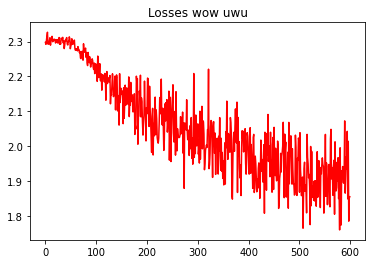

Iteration - 600 - loss 1.8022359609603882
Iteration - 601 - loss 1.9535870552062988
Iteration - 602 - loss 1.7574622631072998
Iteration - 603 - loss 1.9047651290893555
Iteration - 604 - loss 1.8394192457199097
Iteration - 605 - loss 1.9969308376312256
Iteration - 606 - loss 1.8585143089294434
Iteration - 607 - loss 1.8381516933441162
Iteration - 608 - loss 1.946872591972351
Iteration - 609 - loss 2.0019586086273193
Iteration - 610 - loss 1.8688762187957764
Iteration - 611 - loss 1.8615013360977173
Iteration - 612 - loss 2.016085386276245
Iteration - 613 - loss 1.8295694589614868
Iteration - 614 - loss 1.8390358686447144
Iteration - 615 - loss 1.9312245845794678
Iteration - 616 - loss 1.8023302555084229
Iteration - 617 - loss 1.7536392211914062
Iteration - 618 - loss 1.8901827335357666
Iteration - 619 - loss 1.933751106262207
Iteration - 620 - loss 1.9367530345916748
Iteration - 621 - loss 1.8550468683242798
Iteration - 622 - loss 2.1014609336853027
Iteration - 623 - loss 1.982310414314

Iteration - 798 - loss 1.86518394947052
Iteration - 799 - loss 1.9251817464828491


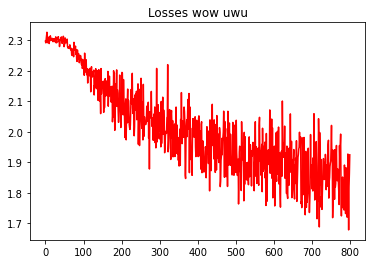

Iteration - 800 - loss 1.8353075981140137
Iteration - 801 - loss 1.814330816268921
Iteration - 802 - loss 1.7354066371917725
Iteration - 803 - loss 1.703182578086853
Iteration - 804 - loss 1.7703999280929565
Iteration - 805 - loss 1.9636088609695435
Iteration - 806 - loss 1.9635813236236572
Iteration - 807 - loss 1.8697413206100464
Iteration - 808 - loss 1.8542944192886353
Iteration - 809 - loss 1.86580491065979
Iteration - 810 - loss 1.9154335260391235
Iteration - 811 - loss 1.9797574281692505
Iteration - 812 - loss 1.7695811986923218
Iteration - 813 - loss 1.9690254926681519
Iteration - 814 - loss 1.7894445657730103
Iteration - 815 - loss 1.7431237697601318
Iteration - 816 - loss 1.8903034925460815
Iteration - 817 - loss 1.758043646812439
Iteration - 818 - loss 1.7653249502182007
Iteration - 819 - loss 2.008683681488037
Iteration - 820 - loss 1.9067856073379517
Iteration - 821 - loss 1.8475008010864258
Iteration - 822 - loss 1.7803268432617188
Iteration - 823 - loss 1.880833506584167

Iteration - 998 - loss 1.8062857389450073
Iteration - 999 - loss 1.7235292196273804


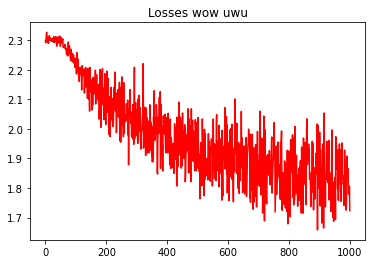

Iteration - 1000 - loss 1.8743524551391602
Iteration - 1001 - loss 1.9110682010650635
Iteration - 1002 - loss 1.870679497718811
Iteration - 1003 - loss 1.7101832628250122
Iteration - 1004 - loss 1.8155781030654907
Iteration - 1005 - loss 1.9498984813690186
Iteration - 1006 - loss 1.8363780975341797
Iteration - 1007 - loss 1.766235589981079
Iteration - 1008 - loss 1.888195276260376
Iteration - 1009 - loss 1.8588907718658447
Iteration - 1010 - loss 1.8437538146972656
Iteration - 1011 - loss 1.7104161977767944
Iteration - 1012 - loss 1.7813599109649658
Iteration - 1013 - loss 1.830790638923645
Iteration - 1014 - loss 1.8018293380737305
Iteration - 1015 - loss 1.7297883033752441
Iteration - 1016 - loss 1.7708206176757812
Iteration - 1017 - loss 1.7809559106826782
Iteration - 1018 - loss 1.8279409408569336
Iteration - 1019 - loss 1.7064688205718994
Iteration - 1020 - loss 1.74860417842865
Iteration - 1021 - loss 1.7244759798049927
Iteration - 1022 - loss 1.811898946762085
Iteration - 1023 -

Iteration - 1192 - loss 1.7867809534072876
Iteration - 1193 - loss 1.6918506622314453
Iteration - 1194 - loss 1.8304526805877686
Iteration - 1195 - loss 1.729688048362732
Iteration - 1196 - loss 1.8463988304138184
Iteration - 1197 - loss 1.7360819578170776
Iteration - 1198 - loss 1.8426839113235474
Iteration - 1199 - loss 1.8075274229049683


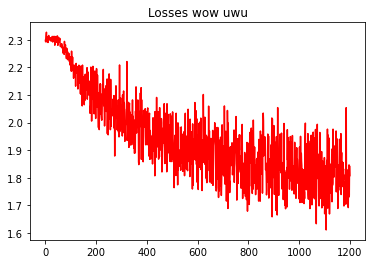

Iteration - 1200 - loss 1.8426119089126587
Iteration - 1201 - loss 1.852277159690857
Iteration - 1202 - loss 1.6509252786636353
Iteration - 1203 - loss 1.7985219955444336
Iteration - 1204 - loss 1.864663004875183
Iteration - 1205 - loss 1.7933188676834106
Iteration - 1206 - loss 1.900554895401001
Iteration - 1207 - loss 1.7724848985671997
Iteration - 1208 - loss 1.812386393547058
Iteration - 1209 - loss 1.729326844215393
Iteration - 1210 - loss 1.7241088151931763
Iteration - 1211 - loss 1.7210149765014648
Iteration - 1212 - loss 1.8344976902008057
Iteration - 1213 - loss 1.7815879583358765
Iteration - 1214 - loss 1.9262113571166992
Iteration - 1215 - loss 1.7648125886917114
Iteration - 1216 - loss 1.6787748336791992
Iteration - 1217 - loss 1.8022236824035645
Iteration - 1218 - loss 1.8504819869995117
Iteration - 1219 - loss 1.790920376777649
Iteration - 1220 - loss 1.7806841135025024
Iteration - 1221 - loss 1.6846816539764404
Iteration - 1222 - loss 1.7060457468032837
Iteration - 1223 

Iteration - 1394 - loss 1.7932347059249878
Iteration - 1395 - loss 1.6871817111968994
Iteration - 1396 - loss 1.710484266281128
Iteration - 1397 - loss 1.792742133140564
Iteration - 1398 - loss 1.7572745084762573
Iteration - 1399 - loss 1.826909065246582


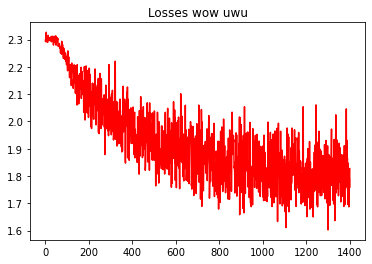

Iteration - 1400 - loss 1.8048053979873657
Iteration - 1401 - loss 1.6931101083755493
Iteration - 1402 - loss 1.6616207361221313
Iteration - 1403 - loss 1.9222803115844727
Iteration - 1404 - loss 1.8416619300842285
Iteration - 1405 - loss 1.8267046213150024
Iteration - 1406 - loss 1.9393630027770996
Iteration - 1407 - loss 1.7664865255355835
Iteration - 1408 - loss 1.7356352806091309
Iteration - 1409 - loss 1.7904841899871826
Iteration - 1410 - loss 1.8525607585906982
Iteration - 1411 - loss 1.9578018188476562
Iteration - 1412 - loss 1.8310554027557373
Iteration - 1413 - loss 1.9584364891052246
Iteration - 1414 - loss 1.9332953691482544
Iteration - 1415 - loss 1.6636550426483154
Iteration - 1416 - loss 1.7777174711227417
Iteration - 1417 - loss 1.6047307252883911
Iteration - 1418 - loss 1.8321533203125
Iteration - 1419 - loss 1.6938743591308594
Iteration - 1420 - loss 1.833215355873108
Iteration - 1421 - loss 1.779840111732483
Iteration - 1422 - loss 1.8636354207992554
Iteration - 1423

Iteration - 1592 - loss 1.7464534044265747
Iteration - 1593 - loss 1.812377691268921
Iteration - 1594 - loss 1.8566930294036865
Iteration - 1595 - loss 1.7269338369369507
Iteration - 1596 - loss 1.7995423078536987
Iteration - 1597 - loss 1.796952486038208
Iteration - 1598 - loss 1.875391960144043
Iteration - 1599 - loss 1.7510976791381836


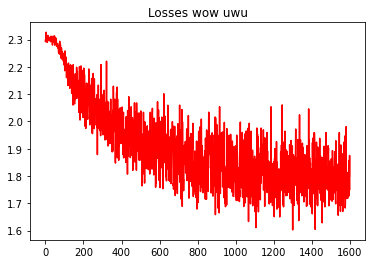

Iteration - 1600 - loss 1.710749626159668
Iteration - 1601 - loss 1.803673505783081
Iteration - 1602 - loss 1.7586290836334229
Iteration - 1603 - loss 1.838606357574463
Iteration - 1604 - loss 1.88587486743927
Iteration - 1605 - loss 1.7146365642547607
Iteration - 1606 - loss 1.8750911951065063
Iteration - 1607 - loss 1.7853680849075317
Iteration - 1608 - loss 1.7807046175003052
Iteration - 1609 - loss 1.8968238830566406
Iteration - 1610 - loss 1.9194310903549194
Iteration - 1611 - loss 1.6662943363189697
Iteration - 1612 - loss 1.9694240093231201
Iteration - 1613 - loss 1.8618935346603394
Iteration - 1614 - loss 1.8271732330322266
Iteration - 1615 - loss 1.8351432085037231
Iteration - 1616 - loss 1.813990592956543
Iteration - 1617 - loss 1.7330490350723267
Iteration - 1618 - loss 1.911385178565979
Iteration - 1619 - loss 1.7745404243469238
Iteration - 1620 - loss 1.9435158967971802
Iteration - 1621 - loss 1.7772622108459473
Iteration - 1622 - loss 1.8502861261367798
Iteration - 1623 -

Iteration - 1792 - loss 1.7445489168167114
Iteration - 1793 - loss 1.7149159908294678
Iteration - 1794 - loss 1.6736232042312622
Iteration - 1795 - loss 1.6009387969970703
Iteration - 1796 - loss 1.8360267877578735
Iteration - 1797 - loss 1.8950430154800415
Iteration - 1798 - loss 1.7869094610214233
Iteration - 1799 - loss 1.6798820495605469


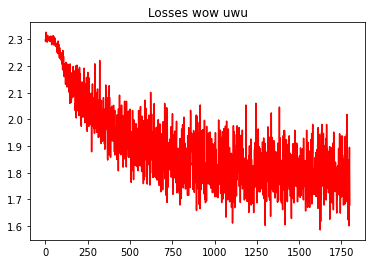

Iteration - 1800 - loss 1.7912126779556274
Iteration - 1801 - loss 1.7562830448150635
Iteration - 1802 - loss 1.660867691040039
Iteration - 1803 - loss 1.8762439489364624
Iteration - 1804 - loss 1.83730947971344
Iteration - 1805 - loss 1.7328617572784424
Iteration - 1806 - loss 1.7375215291976929
Iteration - 1807 - loss 1.6649872064590454
Iteration - 1808 - loss 1.7987480163574219
Iteration - 1809 - loss 1.8997238874435425
Iteration - 1810 - loss 1.6713472604751587
Iteration - 1811 - loss 1.8419160842895508
Iteration - 1812 - loss 2.0022292137145996
Iteration - 1813 - loss 1.8213891983032227
Iteration - 1814 - loss 1.7725753784179688
Iteration - 1815 - loss 1.8309441804885864
Iteration - 1816 - loss 1.9701569080352783
Iteration - 1817 - loss 1.7619740962982178
Iteration - 1818 - loss 1.7322795391082764
Iteration - 1819 - loss 1.8225430250167847
Iteration - 1820 - loss 1.9473259449005127
Iteration - 1821 - loss 1.7422417402267456
Iteration - 1822 - loss 1.850973129272461
Iteration - 182

Iteration - 123 - loss 1.8021252155303955
Iteration - 124 - loss 1.7270559072494507
Iteration - 125 - loss 1.817138433456421
Iteration - 126 - loss 1.8068797588348389
Iteration - 127 - loss 1.9295902252197266
Iteration - 128 - loss 1.5907769203186035
Iteration - 129 - loss 1.743325114250183
Iteration - 130 - loss 1.7684345245361328
Iteration - 131 - loss 1.753466248512268
Iteration - 132 - loss 1.7936053276062012
Iteration - 133 - loss 1.8751674890518188
Iteration - 134 - loss 1.7736992835998535
Iteration - 135 - loss 1.7159500122070312
Iteration - 136 - loss 1.7109568119049072
Iteration - 137 - loss 1.6866847276687622
Iteration - 138 - loss 1.740461826324463
Iteration - 139 - loss 1.7979267835617065
Iteration - 140 - loss 1.937821865081787
Iteration - 141 - loss 1.6718193292617798
Iteration - 142 - loss 1.742055892944336
Iteration - 143 - loss 1.6593120098114014
Iteration - 144 - loss 1.6904916763305664
Iteration - 145 - loss 1.6626362800598145
Iteration - 146 - loss 1.729521512985229

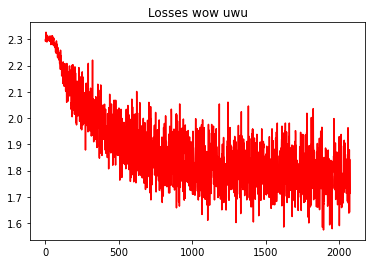

Iteration - 200 - loss 1.799865961074829
Iteration - 201 - loss 1.7994894981384277
Iteration - 202 - loss 1.9723111391067505
Iteration - 203 - loss 1.7489656209945679
Iteration - 204 - loss 1.74143648147583
Iteration - 205 - loss 1.676590919494629
Iteration - 206 - loss 1.772451639175415
Iteration - 207 - loss 1.7727775573730469
Iteration - 208 - loss 1.7854893207550049
Iteration - 209 - loss 1.793737530708313
Iteration - 210 - loss 1.6418153047561646
Iteration - 211 - loss 1.8509507179260254
Iteration - 212 - loss 1.727332353591919
Iteration - 213 - loss 1.7705299854278564
Iteration - 214 - loss 1.8222401142120361
Iteration - 215 - loss 1.7972668409347534
Iteration - 216 - loss 1.793009638786316
Iteration - 217 - loss 1.690492033958435
Iteration - 218 - loss 1.800500512123108
Iteration - 219 - loss 1.7315337657928467
Iteration - 220 - loss 1.8139429092407227
Iteration - 221 - loss 1.8582849502563477
Iteration - 222 - loss 1.7843849658966064
Iteration - 223 - loss 1.716248869895935
Ite

KeyboardInterrupt: 

In [28]:
losses = []
for epoch in range(EPOCHS):
    print(f"Entering epoch {epoch}")
    perceiver.train()
    for batch_no, (features, labels) in enumerate(dataloader):
        features = features.to(device)
        labels = labels.to(device)

        predictions = perceiver(features)
        
        loss = criterion(predictions, labels)
        optimizer.zero_grad()        
        loss.backward()
        
        optimizer.step()

        print(f'Iteration - {batch_no} - loss {loss.item()}')
        losses.append(loss.item())
        if batch_no % 200 == 199:
            plt.plot(losses, 'r-')
            plt.title('Losses wow uwu')
            plt.show()

In [ ]:
perceiver(dataset[0][0].to(device))

In [31]:
paramsAfter = [t.clone() for t in perceiver.parameters()]
equalCount = 0
equal_elemCount = 0
unequalCount = 0
unequal_elemCount = 0
totalDiff = 0
equal_names = []
unequal_names = []
named = list(perceiver.named_parameters())
for i, (paramInit, paramAfter) in enumerate(zip(paramsInit, paramsAfter)):
    if torch.equal(paramInit, paramAfter):
        equalCount += 1
        equal_elemCount += torch.numel(paramAfter)
        equal_names.append( named[i] )
    else:
        unequalCount += 1
        unequal_elemCount += torch.numel(paramAfter)
        totalDiff += torch.sum(torch.abs(paramAfter - paramInit))
        unequal_names.append( named[i] )

print(equalCount, unequalCount)
if unequalCount == 0:
    print('bro did nothing change??')
else:
    print(totalDiff / unequal_elemCount)
len(paramsAfter)
garbage = FMPreprocess()
print(equal_elemCount - torch.numel(garbage.encoding))
for name in map(lambda p: p[0], equal_names):
    print(name)
    
print('\n\n')
for name in map(lambda p: p[0], unequal_names):
    print(name)

1 229
tensor(0.0095, device='cuda:0', grad_fn=<DivBackward0>)
0
preprocess.encoding



preprocess.conv0.weight
perceiver.q_in
perceiver.q_out
perceiver.encoder.block.0.q_norm.weight
perceiver.encoder.block.0.q_norm.bias
perceiver.encoder.block.0.kv_norm.weight
perceiver.encoder.block.0.kv_norm.bias
perceiver.encoder.block.0.mlp_norm.weight
perceiver.encoder.block.0.mlp_norm.bias
perceiver.encoder.block.0.attn.q_proj_weight
perceiver.encoder.block.0.attn.k_proj_weight
perceiver.encoder.block.0.attn.v_proj_weight
perceiver.encoder.block.0.attn.in_proj_bias
perceiver.encoder.block.0.attn.out_proj.weight
perceiver.encoder.block.0.attn.out_proj.bias
perceiver.encoder.block.0.mlp.lin_in.weight
perceiver.encoder.block.0.mlp.lin_in.bias
perceiver.encoder.block.0.mlp.lin_out.weight
perceiver.encoder.block.0.mlp.lin_out.bias
perceiver.encoder.block.1.in_norm.weight
perceiver.encoder.block.1.in_norm.bias
perceiver.encoder.block.1.mlp_norm.weight
perceiver.encoder.block.1.mlp_norm.bias
perceiver.e

In [29]:
testloader = DataLoader(testset, batch_size=1)
acc_count = 0
count = 0
perceiver.eval()
for i, (feature, label) in enumerate(testloader):
    feature = feature.to(device)
    label = label.to(device)
    prediction = perceiver(feature)
    prediction = torch.argmax(prediction)
    
    if prediction == label:
        acc_count += 1
        
    count += 1
    
    if i == 500:
        break
        
print(acc_count / count)

0.4231536926147705
